In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import rsa

## Encoding and Decoding Functions

In [33]:
def audio_from_wav(filename):
    fs, data = wavfile.read(filename)
    audio = (data[:,0] + data[:,1]) // 2
    data[:,0] = audio
    data[:,1] = audio
    filename = filename.split('.')[0] + '_mono.wav'
    wavfile.write(filename, fs, data)
    return fs, audio;

def audio_to_wav(audio, filename, fs, N_original):
    data = np.zeros((N_original, 2)).astype(np.int16)
    data[:,0] = audio[0:N_original]
    data[:,1] = audio[0:N_original]
    wavfile.write(filename, fs, data)

def pad_audio(audio, fs, df):
    N = len(audio)
    N_min = fs/df
    N_req = int((N // N_min + 1) * N_min - N)
    print(N_req)
    pad = np.linspace(0, 0, N_req)
    audio = np.concatenate((audio, pad))
    return audio

def remove_low_frequencies(audio, fs, f_max):
    audio_fft = np.fft.rfft(audio)
    audio_fft[0:len(audio)*f_max//fs] = 0
    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def add_data(audio, data, ampl, fs, df, f_min):
    f_data = np.around(np.linspace(f_min, f_min + (len(data)-1) * df, len(data)), 1)
    f_audio = np.around(np.fft.rfftfreq(len(audio), 1/fs), 1)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] == f_audio[f]):
            audio_fft[f] = ampl * data[f_d]
            f_d += 1
            if f_d == len(f_data):
                break

    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def recover_data(audio, data_ampl, data_len, fs, df, f_min):
    data = np.zeros(data_len)

    f_data = np.around(np.linspace(f_min, f_min + (len(data)-1) * df, len(data)), 1)
    f_audio = np.around(np.fft.rfftfreq(len(audio), 1/fs), 1)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] == f_audio[f]):
            if (audio_fft[f] > data_ampl/2):
                data[f_d] = 1
            f_d += 1
            if f_d == len(f_data):
                break
    return data





## Encryption Functions

In [34]:

def create_keys(length):
    public_key, private_key = rsa.newkeys(length)

    with open('public_key.pem', 'wb') as f:
        f.write(public_key.save_pkcs1())
    
    with open('private_key.pem', 'wb') as f:
        f.write(private_key.save_pkcs1())
        
    return public_key, private_key

def encrypt_data(message, private_key):
    return rsa.sign(message.encode(), private_key, 'SHA-1')

def Check_data(message, sign_message , public_key):
    try:
        rsa.verify(message.encode(), sign_message, public_key)
        return True
    except:
        return False
    

# def getdatafromadi_sec_ave(audio, fs):
    

    output = np.zeros(8)
   



    Sec_total = np.zeros(8)
    Sec_num_of_enters = np.zeros(8)
    Sec_average = np.zeros(8)
    Sec_compare_count = np.zeros(8)

    
    # start inputes
    f_start = 100
    f_end = 900
    numpersec = 50



    df = 1
    print(df)
    
    # ]foria transform audio
    audio = pad_audio(audio, fs, df)
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    print(len(audio))
    print(f_full)


    # calculate average for each section
    for i in range(len(f_full)):
        if (f_full[i]%df == 0.0):
            for j in range(8):
                temp_start = f_start + j * 100
                temp_end = temp_start + 100
                if f_full[i] >= temp_start and f_full[i] <= temp_end:
                    Sec_total[j] += np.abs(audio_fft[i])
                    Sec_num_of_enters[j] += 1
        print(np.abs(audio_fft[i]))
                
    for i in range(8):
        Sec_average[i] = Sec_total[i] / Sec_num_of_enters[i]
        print(Sec_average[i])



    # calculate num above or below for each section
    for i in range(len(f_full)):
        for j in range(8):
            temp_start = f_start + j * 100
            temp_end = temp_start + 100
            if f_full[i] >= temp_start and f_full[i] <= temp_end:
                if np.abs(audio_fft[i]) >= Sec_average[j]:
                    Sec_compare_count[j] += 1
                else:
                    Sec_compare_count[j] -= 1

                
                    
    for i in range(8):
        if Sec_compare_count[i] > 0:
            output[i] = 1
        else:
            output[i] = 0


    return output


def getdatafrom_sec_total_ave(adio_name):

    fs, audio = audio_from_wav(adio_name)


    total = 0
    numtotal = 0

    Sec_compare_count = np.zeros(8)

    output = np.zeros(8)
    
    # start inputes
    f_start = 100
    f_end = 900
    numpersec = 10

    df = (f_end - f_start)/numpersec

    
    # fouriatransform audio
    audio = pad_audio(audio, fs, df)
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    
    # calculate average for all
    for i in range(len(f_full)):
        f_full_round = np.around(f_full[i], 2)
        if (f_full_round%df == 0):
            if f_full[i] >= f_start and f_full[i] <= f_end:
                total += np.abs(audio_fft[i])
                numtotal += 1
            
                
    ave = total / numtotal

    # calculate num above or below for each section
    for i in range(len(f_full)):
        f_full_round = np.around(f_full[i], 2)
        if (f_full_round%df == 0):
            for j in range(8):
                temp_start = f_start + j * 100
                temp_end = temp_start + 100
                if f_full[i] >= temp_start and f_full[i] <= temp_end:
                    if np.abs(audio_fft[i]) >= ave:
                        Sec_compare_count[j] += 1
                    else:
                        Sec_compare_count[j] -= 1
                        
         
    for i in range(8):
        if Sec_compare_count[i] > 0:
            output[i] = 1
        else:
            output[i] = 0


    return output


def convert_to_ascii(input):
    int_input = [int(i) for i in input]
    binary_string = ''.join(str(bit) for bit in int_input)
    decimal_value = int(binary_string, 2)
    ascii_char = chr(decimal_value)
    return ascii_char

def bytes_to_binary(bytes_obj):
    return ''.join(format(byte, '08b') for byte in bytes_obj)

def binary_to_bytes(binary_str):
    return bytes(int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8))


def get_data(audio_name,private_key):
    message = convert_to_ascii(getdatafrom_sec_total_ave(audio_name))
    sign_message = encrypt_data(message, private_key)
    bin_sign_message=bytes_to_binary(sign_message)    
    bin_data = [int(bit) for bit in bin_sign_message]
    return bin_data


 

def check_data(audio_name, bin_data_arry , public_key):
    message = convert_to_ascii(getdatafrom_sec_total_ave(audio_name))
    bin_data = ''.join(str(bit) for bit in bin_data_arry)
    sign_message = binary_to_bytes(bin_data)
    return Check_data(message, sign_message, public_key)
    

## Test

In [37]:
public_key, private_key = create_keys(365);

#encrypt the data
bin_data = get_data('AudioFiles/bumblebee_small.wav',private_key)


# print the binary data that gets put into the song
print(bin_data)



#dencrypt the data
check = check_data('AudioFiles/bumblebee_small.wav',bin_data,public_key)


print(check)










157
b'\x04\x06\x12Nh\x8b\x08\x9f\x9bY\xd7\xb9\x0fC\xd4\xc5M\xfe\xf8*\xb2\x11\x9e\xcc\xf4P\xf9\x94\x05\xf1\xa4\xe1\x91>\x82X4\x83h\xfb?\xfe\xe3\x00\x97:'
00000100000001100001001001001110011010001000101100001000100111111001101101011001110101111011100100001111010000111101010011000101010011011111111011111000001010101011001000010001100111101100110011110100010100001111100110010100000001011111000110100100111000011001000100111110100000100101100000110100100000110110100011111011001111111111111011100011000000001001011100111010
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 

## Helper Functions

In [ ]:
def plot_fft(audio, fs, f_max = 250):
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)
    plt.figure()
    plt.plot(f_full, np.abs(audio_fft))
    plt.xlim([0, f_max])
    plt.ylim([0, 1.5e7])
    plt.title('Song fft')

90
7875
[0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.]


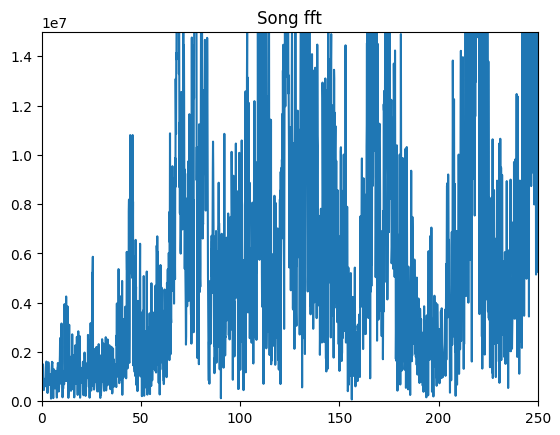

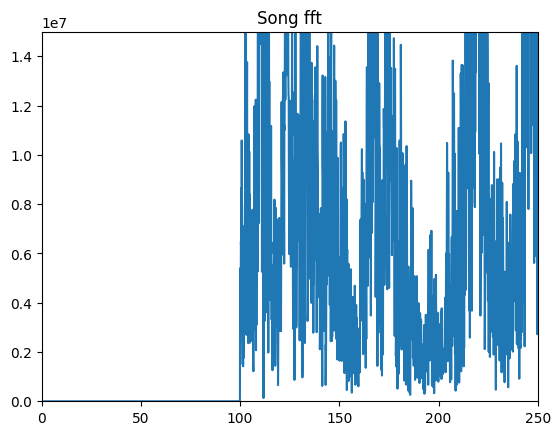

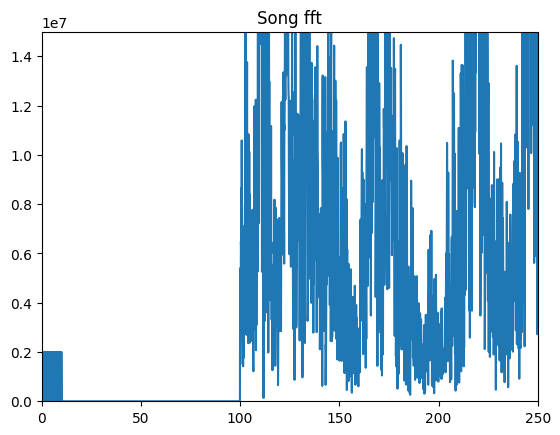

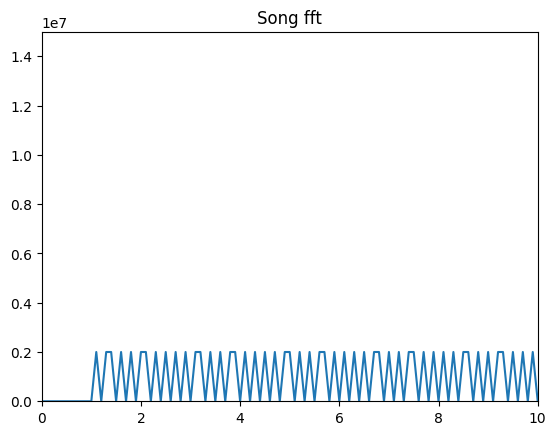

In [ ]:
DELTA_FREQUENCIES = 0.1 # Hz
LOWEST_FREQUENCY = 1 # Hz
data = [0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
print(len(data))

fs, audio = audio_from_wav('AudioFiles/bumblebee_small.wav')
N_original = len(audio)
plot_fft(audio, fs)

audio = pad_audio(audio, fs, DELTA_FREQUENCIES)
audio = remove_low_frequencies(audio, fs, 100)
plot_fft(audio, fs)

audio = add_data(audio, data, 0.2e7, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY)
plot_fft(audio, fs)
plot_fft(audio, fs, 10)
audio_to_wav(audio, 'AudioFiles/bumblebee_small_with_data.wav', fs, N_original)

data_r = recover_data(audio, 0.2e7, len(data), fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY)
print(data_r)
